# Recommendation System using Collaborative Filtering

In this notebook we will explore recommending system using collaborative filtering


### 1. Load data and preprocessing 

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import random


### functions for similarity calculation
def euclidean(s1,s2):
    diff = s1 - s2
    return 1/(1+np.sqrt(np.sum(diff**2)))

def cosine(s1,s2):
    return np.sum(s1*s2)/np.sqrt(np.sum(s1**2)*np.sum(s2**2))    

def pearson(s1,s2):
    s1_c = s1-s1.mean()
    s2_c = s2-s2.mean()
    return np.sum(s1_c*s2_c)/np.sqrt(np.sum(s1_c**2)*np.sum(s2_c**2))    


In [428]:
orders = pd.read_csv('../data/full_data.csv')
clustered = pd.read_csv('../data/clustered_orders.csv')


In [429]:
orders.head()

,OrderId,UserId,RestaurantId,Date,Rating,Comments,Address,Count,ItemId,Price,ViewCount,Name,Description,SearchVector,Type
0,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,211,15.0,0.0,Tableside Spinach Salad,NaN,'almond':8 'babi':4 'bacon':11 'jack':10 'mont...,Main
1,8,113,110,2020-03-28 08:15:25.615002,NaN,NaN,"{'Id': 4, 'Lat': 49.28319399999999, 'Lng': -12...",1,218,27.0,0.0,King Crab,NaN,'blanc':9 'buerr':8 'caper':7 'char':3 'chilli...,Main
2,293,4,121,2020-05-13 01:20:59.267256,NaN,NaN,NaN,1,440,14.0,1097.0,Joojeh Kabab With Rice,One skewer of chicken breast marinated with yo...,'bbq':14 'chicken':11 'joojeh':1 'juic':9 'kab...,Main
3,294,3,121,2020-05-13 17:34:35.519326,NaN,NaN,NaN,1,455,1.5,9.0,Regular Coffee,NaN,'coffe':2 'regular':1,Drink
4,297,142,121,2020-05-14 00:08:48.756423,NaN,NaN,NaN,1,540,9.9,485.0,Kashk Bademjan,"Barbequed eggplant, lentils, fried onions, gar...",'bademjan':2 'bbq':8 'egg':10 'eggplant':6 'ga...,Main


In [430]:
orders.columns = [c.lower() for c in orders.columns]
orders.columns

Index(['orderid', 'userid', 'restaurantid', 'date', 'rating', 'comments',
       'address', 'count', 'itemid', 'price', 'viewcount', 'name',
       'description', 'searchvector', 'type'],
      dtype='object')

Keep the columns we need

In [431]:
data = orders[['orderid', 'userid', 'date', 'rating','itemid','name','description']]

Lets keep the user info with some extra added columns to a different datafram

In [432]:
userids = set(data['userid'])
user_info = pd.DataFrame(userids,columns = ['userid']).set_index('userid')

user_info['gender'] = [random.choice(['F','M']) for i in range(user_info.shape[0])]
user_info['age'] = [random.randrange(18,70,1) for i in range(user_info.shape[0])]
user_info.head()

,gender,age
userid,,
1,F,36
3,M,35
4,F,46
5,F,37
26,F,65


Lest add gender and age columns to the order data too

In [433]:
data = pd.merge(data,user_info,left_on='userid',right_on='userid', how ='left')

In [434]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24109 entries, 0 to 24108
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orderid      24109 non-null  int64  
 1   userid       24109 non-null  int64  
 2   date         24109 non-null  object 
 3   rating       1757 non-null   float64
 4   itemid       24109 non-null  int64  
 5   name         24109 non-null  object 
 6   description  14025 non-null  object 
 7   gender       24109 non-null  object 
 8   age          24109 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.8+ MB


As seen above we have not enough ratings for the food. Therefore we compe up with a solution to increase the rate of collabortion with adding a rating to foods that the user has ordered equal to one random choice of 3,4,5. What that means is, that the user is probably liked the food that ordered it, but might not left a comment or rating, also if she ordered it it meanse she liked the ingredient or that food in general.

So lets add that arbitarary rate to the ordered food.

In [435]:
# get the unique number of records
data.nunique()

orderid        10868
userid          4539
date           10868
rating             5
itemid           359
name             320
description      225
gender             2
age               52
dtype: int64

Create a column to have random numbers from [3,4,5].

In [436]:
data['random'] = [random.randrange(3, 6, 1) for i in range(data.shape[0])]
print(data['random'].value_counts())

5    8059
4    8036
3    8014
Name: random, dtype: int64


Fill all the NaN values with a record from random column

In [437]:
data['rating'].fillna(value = data['random'], inplace= True)

In [438]:
data['rating'].isna().sum()

0

In [439]:
# remove all the rows with no ratings
# data = data[~(data['rating'].isna())].reset_index()

In [440]:
data['rating'].value_counts()

5.0    8716
4.0    7693
3.0    7574
1.0      90
2.0      36
Name: rating, dtype: int64

In [441]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24109 entries, 0 to 24108
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orderid      24109 non-null  int64  
 1   userid       24109 non-null  int64  
 2   date         24109 non-null  object 
 3   rating       24109 non-null  float64
 4   itemid       24109 non-null  int64  
 5   name         24109 non-null  object 
 6   description  14025 non-null  object 
 7   gender       24109 non-null  object 
 8   age          24109 non-null  int64  
 9   random       24109 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 2.0+ MB


### Split Data into Train and Test Data

In [442]:
split_perc= int(len(data) * 0.80)
train_data = data[:split_perc]
test_data = data[split_perc:]

### Analysis of Data

/var/folders/pm/804wbvdx4lz30mqcr3mys38r0000gn/T/ipykernel_902/2780585729.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


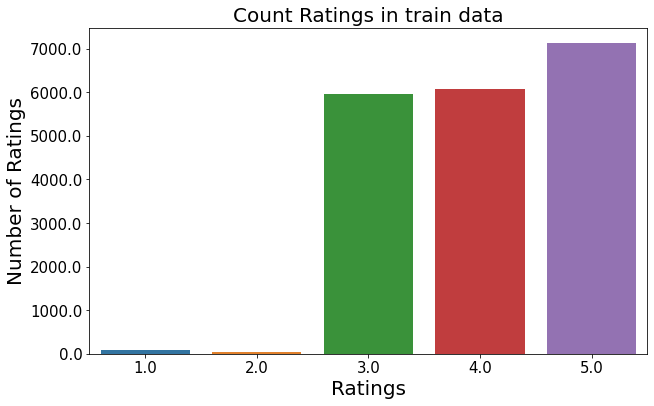

In [443]:
# plot the rating distribution in training data
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [444]:
user_rating_no = train_data.groupby("userid")["rating"].count().sort_values(ascending = False)
user_rating_no.head(10)

userid
863     177
1004     64
836      53
1629     45
2558     43
1409     40
1628     35
420      34
1252     34
1329     33
Name: rating, dtype: int64

In [445]:
item_rating_no= train_data.groupby("itemid")["rating"].count().sort_values(ascending = False)
item_rating_no.head(10)

itemid
82659    1757
81555    1055
81558     896
81553     820
82674     733
82676     661
81554     518
523       496
81557     446
82653     441
Name: rating, dtype: int64

### Check Cold Start Problem for Users

Here, 28% of total users are new and they will have no proper rating available. So, this can bring the issue of the cold start problems.

In [446]:
total_users = len(np.unique(data["userid"]))
train_users = len(np.unique(train_data["userid"]))
test_users = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(test_users, np.round((test_users/total_users)*100), 2))

Total no. of Users = 4539
No. of Users in train data= 3673
No. of Users not present in train data = 866(19.0%)


### Minimal Recommendation Engine: Simple Mean Rating

In [447]:
def rmse_calculate(y_pred,y_true):
    return np.sqrt(np.nanmean((y_pred - y_true)**2))

def evaluate(prediction_f,data):
    ids_toestimat = zip(data.userid,test_data.itemid)
    estimated = np.array([prediction_f(userid,itemid,data) for (userid,itemid) in ids_toestimat])
    reals = data['rating'].values
    return rmse_calculate(estimated,reals)

def dummy_estimate(userid,itemid):
    return 3    

def content_mean(userid,itemid,data):
    condition = data.userid == userid
    return data.loc[condition]['rating'].mean()

def colab_mean(userid,itemid,data):
    item_condition = data.itemid == itemid
    user_condition = data.userid != userid
    result = data.loc[item_condition & user_condition ][['orderid','userid','itemid','name','rating']]
    #print(result)
    return result['rating'].mean()



In [448]:
evaluate(colab_mean,test_data)

0.8487021817318197

In [449]:
evaluate(content_mean,test_data)

0.7051427134034722

### Colaborative Recommendation Engine:

In [450]:
rating_mtx = pd.pivot_table(train_data,values='rating',index = 'userid',columns ='itemid')

In [451]:
gender_mtx = pd.pivot_table(train_data,values='rating',index = 'itemid',columns ='gender', aggfunc=np.mean)

### Colaborative Recommendation based on gender and age

In [452]:
class CollabGenderRec:
    def learn(self,data):
        self.means_by_gender = pd.pivot_table(data,values='rating',index='itemid',columns='gender',aggfunc=np.mean)
   
    def estimate(self,userid,itemid,data):
        if itemid not in self.means_by_gender.index:
            return 3

        user_gender = user_info.loc[userid]['gender']
        if ~np.isnan(self.means_by_gender.loc[itemid][user_gender]):
            return self.means_by_gender.loc[itemid][user_gender]
        else:
            return self.means_by_gender.loc[itemid].mean()


class CollabAgeRec:
    def learn(self,data):
        self.means_by_age = pd.pivot_table(data,values='rating',index='itemid',columns='age',aggfunc=np.mean)
   
    def estimate(self,userid,itemid,data):
        if itemid not in self.means_by_age.index:
            return 3

        user_age = user_info.loc[userid]['age']
        if ~np.isnan(self.means_by_age.loc[itemid][user_age]):
            return self.means_by_age.loc[itemid][user_age]
        else:
            return self.means_by_age.loc[itemid].mean()


In [454]:
reco = CollabGenderRec()
reco.learn(test_data)
evaluate(reco.estimate,test_data)


0.7737312565891944

In [455]:
reco = CollabAgeRec()
reco.learn(train_data)
evaluate(reco.estimate,test_data)

0.9525199452015628

### Colaborative Recommendation based on user profile and similarity matrix

In [ ]:
class CollabPearsonRec:
    def learn(self,data):
        self.all_users_profiles = pd.pivot_table(data,values='rating',index='userid',columns='itemid',aggfunc=np.mean)
        self.all_users_profiles = self.all_users_profiles.fillna(0)

   
    def estimate(self,userid,itemid,data):
        user_condition = data.userid != userid
        item_condition = data.itemid == itemid
        rating_by_others = data.loc[user_condition & item_condition]
        if rating_by_others.empty:
            return 3

        rating_by_others.set_index('userid',inplace=True)
        their_ids = rating_by_others.index
        their_ratings = rating_by_others.rating
        their_profile = self.all_users_profiles.loc[their_ids]
        if userid in self.all_users_profiles.index:
              user_profile = self.all_users_profiles.loc[userid]
        else:
            return 3

        sims = their_profile.apply(lambda profile: pearson(profile,user_profile), axis=1)
        ratings_sims = pd.DataFrame({'sim':sims,'rating':their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)


In [457]:
rec = CollabPearsonRec()
rec.learn(test_data)
evaluate(rec.estimate,test_data)


0.8548117150445377